In [126]:
import numpy as np
import torch
import torchvision

from torchvision.datasets import CIFAR100

In [127]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [128]:
train_data = CIFAR100(download=True, root='data', transform=train_transform)
test_data = CIFAR100(root='data', train=False, transform=test_transform)

Files already downloaded and verified


In [129]:
import json

CIFAR100_LABELMAP_PATH = "cifar100_labels.json"


def parse_json(path):
    with open(path, "rt") as f:
        return json.load(f)

LABEL_MAP = {int(k): v for k, v in parse_json(CIFAR100_LABELMAP_PATH).items()}

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt


def show_img(img, text=None, interpolation='bilinear'):
    assert isinstance(img, np.ndarray)
    assert len(img.shape) == 3
    assert img.shape[2] == 3
    
    fig, ax = plt.subplots(1)
    ax.imshow(img, interpolation=interpolation)
    if text is not None:
        assert isinstance(text, str)
        ax.text(3, img.shape[0] - 3, text, bbox={'facecolor': 'white', 'pad': 10})

def show_sample(data_sample):
    img, label = data_sample
    img = img.numpy()
    label = LABEL_MAP[label]
    img = np.transpose(img, [1, 2, 0])  # CHW -> HWC
    show_img(img, f'Class: "{label}"')

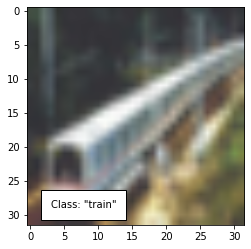

In [131]:
show_sample(train_data[6])

## Model

In [132]:
from torch.nn import Module


class CIFARNormalization(Module):
    RGB_MEAN = (0.5074, 0.4867, 0.4411)
    RGB_STD = (0.2675, 0.2565, 0.2761)
    
    def __init__(self):
        super().__init__()
        self.norm = torchvision.transforms.Normalize(
            mean=self.RGB_MEAN,
            std=self.RGB_STD
        )
    
    def forward(self, x):
        return self.norm(x)

In [136]:
class PatchGenerator(Module):
    def __init__(self, patch_size=4, img_size=32, projection_dim=64):
        super().__init__()
        assert patch_size > 0
        self.patch_size = patch_size
        self.conv = torch.nn.Conv2d(
            in_channels=3,
            out_channels=projection_dim,
            kernel_size=patch_size,
            stride=self.patch_size,
            padding=0,
        )
        patch_qty = (img_size // patch_size) ** 2
        self.position_encoding = torch.nn.Embedding(
            num_embeddings=patch_qty,
            embedding_dim=projection_dim,
        )
        self.indices = torch.range(0, patch_qty-1).to(torch.int32)
    
    def forward(self, x):
        b, c, h, w = x.shape
        assert w % self.patch_size == 0
        assert h % self.patch_size == 0
        embeddings = self.conv(x)
        b, dims, hsz, wsz = embeddings.shape
        embeddings = torch.reshape(embeddings, [b, dims, wsz * hsz])
        embeddings = torch.permute(embeddings, [0, 2, 1])
        position_embeddings = self.position_encoding(self.indices)
        return embeddings + position_embeddings
        

In [150]:
class AttentionLayer(Module):
    def __init__(self, embed_dim=64):
        super().__init__()
        self.query_projection = torch.nn.Linear(
            in_features=embed_dim,
            out_features=embed_dim,
        )
        self.key_projection = torch.nn.Linear(
            in_features=embed_dim,
            out_features=embed_dim,
        )
        self.value_projection = torch.nn.Linear(
            in_features=embed_dim,
            out_features=embed_dim,
        )
        self.norm = torch.sqrt(torch.Tensor(embed_dim))

    def forward(self, q_seq, kv_seq=None):
        b, _, dims = q_seq.shape
        
        x = q_seq
        x_ = q_seq if kv_seq is None else kv_seq
        
        query = torch.reshape(
            self.query_projection(torch.reshape(x, [-1, dims])),
            [b, -1, dims],
        )
        key = torch.reshape(
            self.key_projection(torch.reshape(x_, [-1, dims])),
            [b, -1, dims],
        )
        value = torch.reshape(
            self.value_projection(torch.reshape(x_, [-1, dims])),
            [b, -1, dims],
        )
        
        attention = torch.nn.functional.softmax(
            torch.matmul(query, key.T) / self.norm,
            dim=-1
        )
        
        return torch.matmul(
            attention,
            value,
        )

In [151]:
example = torch.unsqueeze(train_data[6][0], 0)

patch_gen = PatchGenerator()
seq = patch_gen(example)

/var/folders/3q/2zcvm1657mzdfv8n07vmkwr40000gn/T/ipykernel_1732/450048191.py:18: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  self.indices = torch.range(0, patch_qty-1).to(torch.int32)


In [152]:
attention = AttentionLayer()
res = attention(seq)

In [153]:
res.shape

torch.Size([64, 64, 64])